In [1]:
"""Example showing the use of SOCEMO for multi-objective optimization"""

# Copyright (C) 2024 National Renewable Energy Laboratory

# This program is free software: you can redistribute it and/or modify
# it under the terms of the GNU General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.

# This program is distributed in the hope that it will be useful,
# but WITHOUT ANY WARRANTY; without even the implied warranty of
# MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
# GNU General Public License for more details.

# You should have received a copy of the GNU General Public License
# along with this program.  If not, see <http://www.gnu.org/licenses/>.

__authors__ = ["Weslley S. Pereira"]
__contact__ = "weslley.dasilvapereira@nrel.gov"
__maintainer__ = "Weslley S. Pereira"
__email__ = "weslley.dasilvapereira@nrel.gov"
__credits__ = ["Weslley S. Pereira"]
__version__ = "0.3.0"
__deprecated__ = False

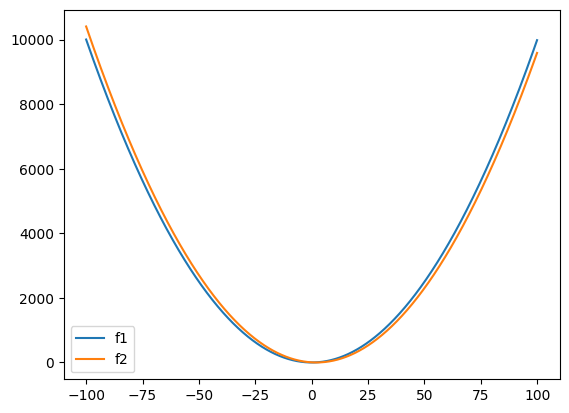

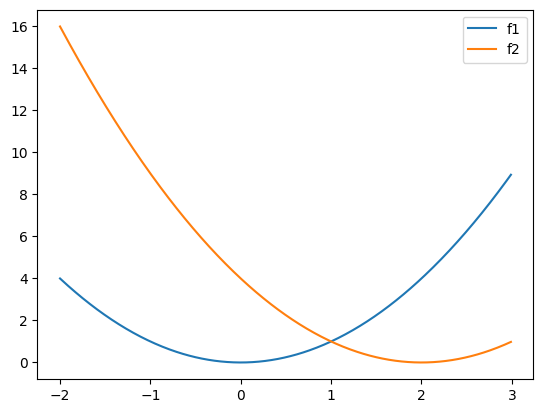

In [2]:
# Problem description
from matplotlib import pyplot as plt
import numpy as np

bounds = [(-100, 100)]

def objf(x):
    return [[xi[0]**2, (xi[0]-2)**2] for xi in x]

x = np.arange(-100, 100, 0.1)
fx = objf([[xi] for xi in x])
f1x = [f[0] for f in fx]
f2x = [f[1] for f in fx]
plt.plot(x, f1x, label='f1')
plt.plot(x, f2x, label='f2')
plt.legend()
plt.show()

x = np.arange(-2, 3, 0.01)
fx = objf([[xi] for xi in x])
f1x = [f[0] for f in fx]
f2x = [f[1] for f in fx]
plt.plot(x, f1x, label='f1')
plt.plot(x, f2x, label='f2')
plt.legend()
plt.show()

In [3]:
from blackboxopt.rbf import RbfModel
from blackboxopt.acquisition import UniformAcquisition, CoordinatePerturbation
from blackboxopt.sampling import NormalSampler

maxeval = 100
ncand = 500
sigma = 0.02
reltol = 0.05
tol = 0.001

localAcquisition = CoordinatePerturbation(maxeval, NormalSampler(ncand,sigma), weightpattern=(0.95,), reltol=reltol)
globalAcquisition = UniformAcquisition(ncand, 0.95, tol)

In [4]:
%%capture outputSOCEMO
from blackboxopt.optimize import socemo
np.random.seed(3)

surrogateModels = [RbfModel(), RbfModel()]
res = socemo(objf, bounds, maxeval, surrogateModels=surrogateModels, acquisitionFunc=localAcquisition, acquisitionFuncGlobal=globalAcquisition, disp=True)

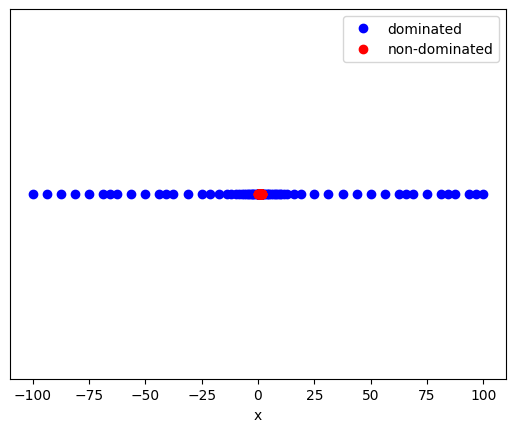

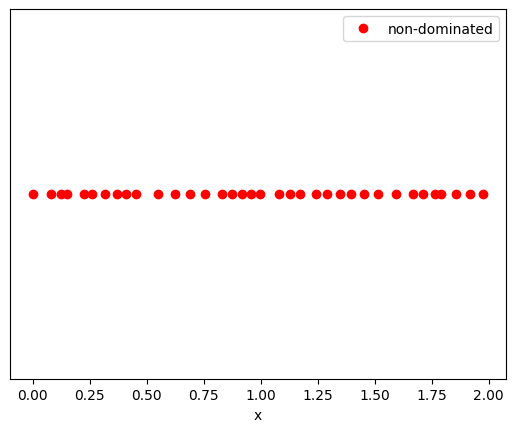

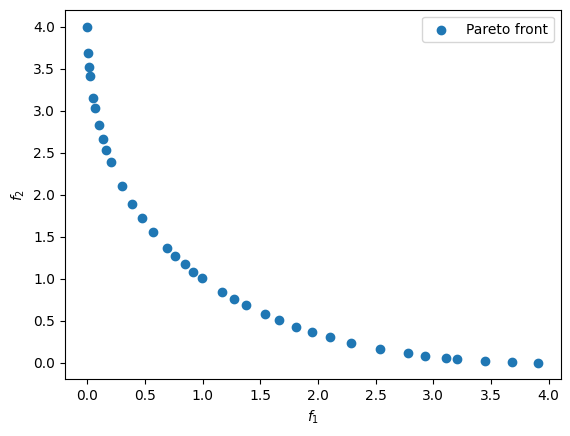

In [5]:
from matplotlib import pyplot as plt

samples = res.samples.flatten()
f1 = res.fsamples[:,0].flatten()
f2 = res.fsamples[:,1].flatten()
nondominated = res.x
paretoFront = res.fx

plt.plot(samples, np.ones_like(samples), 'bo', label="dominated")
# plt.plot(samples, f2, 'bo')
plt.plot(nondominated, np.ones_like(nondominated), 'ro', label="non-dominated")
# plt.plot(nondominated, paretoFront[:,1], 'ro')
plt.xlabel("x")
plt.yticks([], [])
plt.legend()
plt.show()

plt.plot(nondominated, np.ones_like(nondominated), 'ro', label="non-dominated")
# plt.plot(nondominated, paretoFront[:,1], 'ro')
plt.xlabel("x")
plt.yticks([], [])
plt.legend()
plt.show()

# plt.scatter(res.fsamples[:, 0], res.fsamples[:, 1], label="Samples")
plt.scatter(res.fx[:, 0], res.fx[:, 1], label="Pareto front")
plt.xlabel(r"$f_1$")
plt.ylabel(r"$f_2$")
plt.legend()
plt.show()

In [6]:
out = outputSOCEMO.stdout.split('\n')

samplesUpToIter = []
for i in range(len(out)):
    if "fEvals:" in out[i]:
        samplesUpToIter.append(int(out[i].split()[1]))
samplesUpToIter.append(maxeval)

samplesUpToIter

[4,
 10,
 14,
 17,
 20,
 23,
 26,
 29,
 32,
 35,
 38,
 41,
 44,
 46,
 49,
 52,
 55,
 58,
 61,
 64,
 67,
 70,
 73,
 76,
 79,
 82,
 85,
 88,
 91,
 94,
 97,
 100]

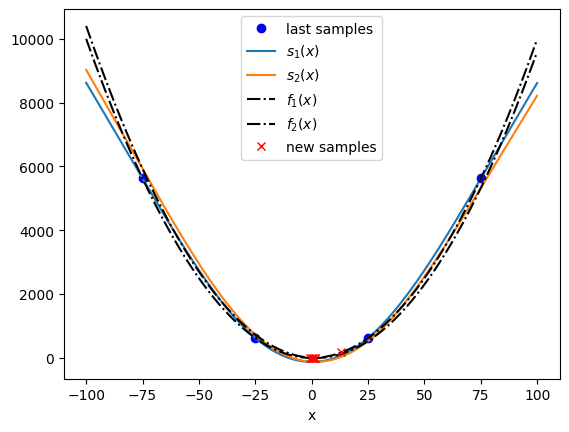

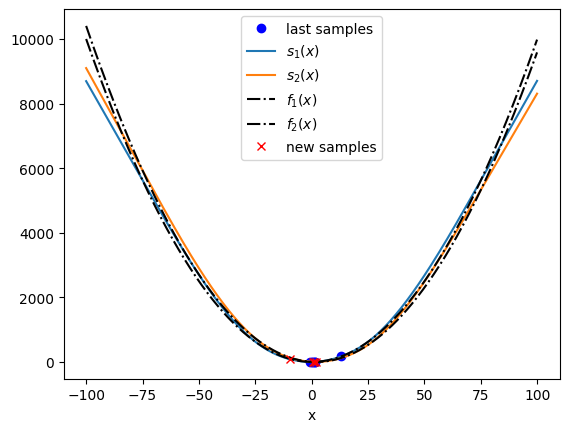

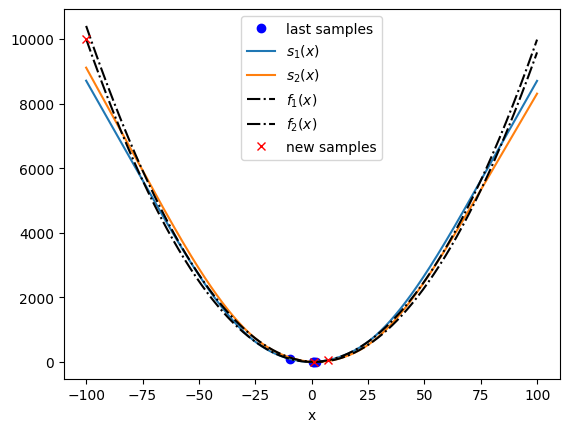

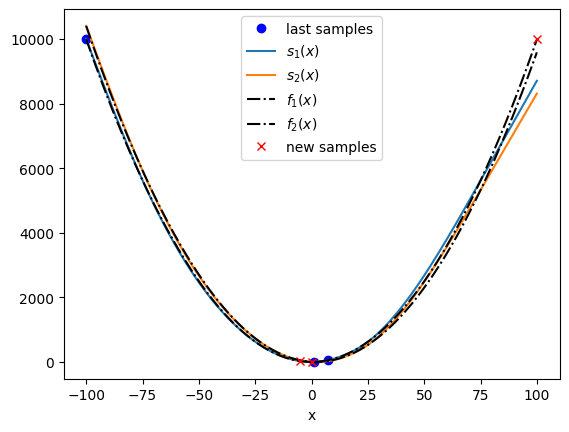

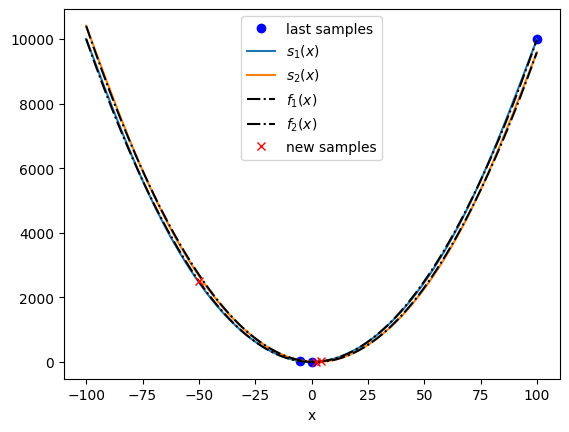

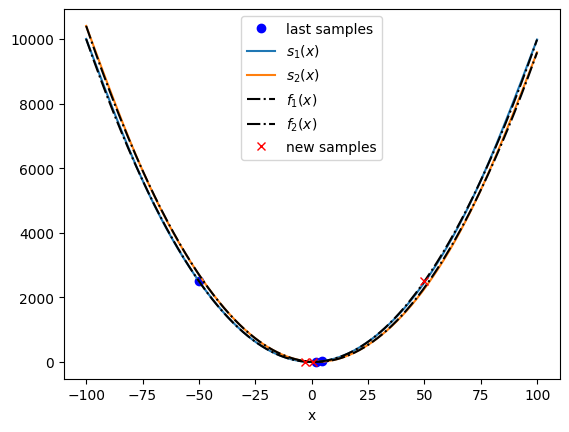

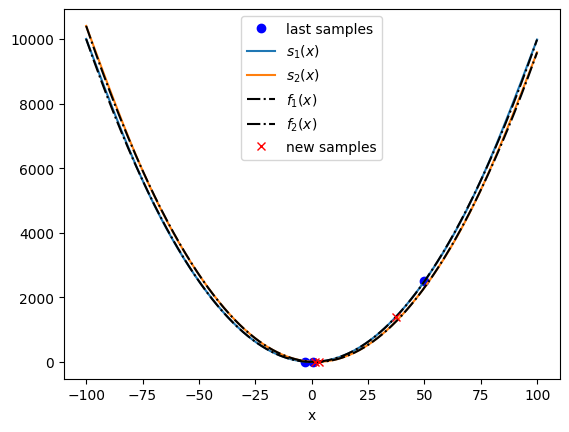

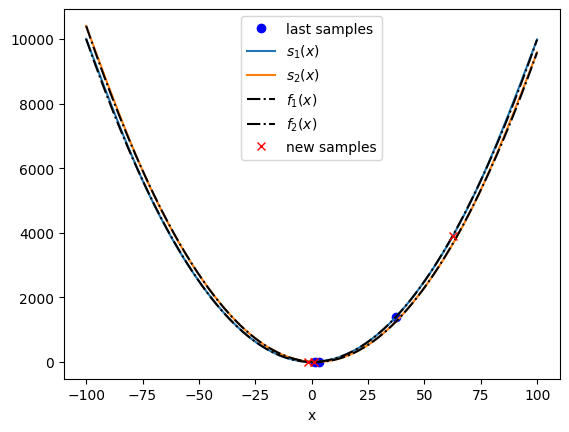

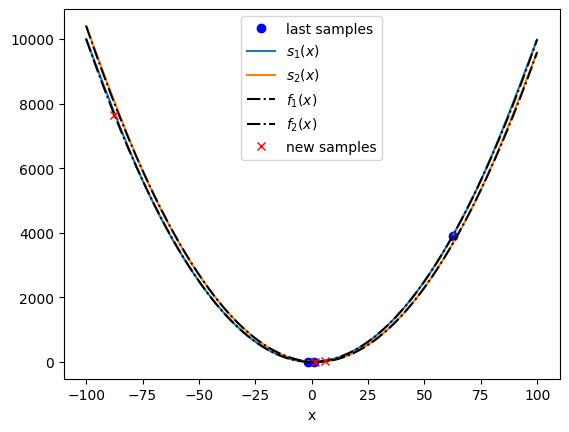

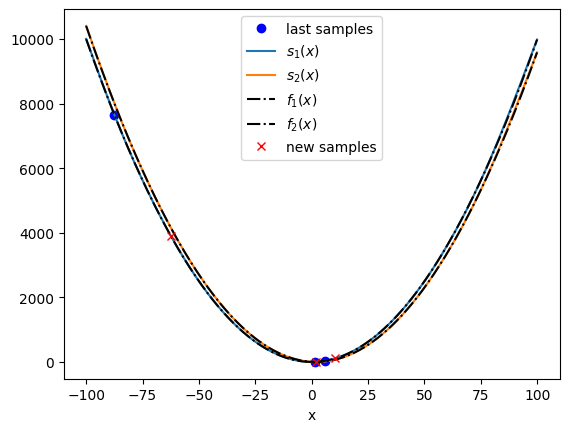

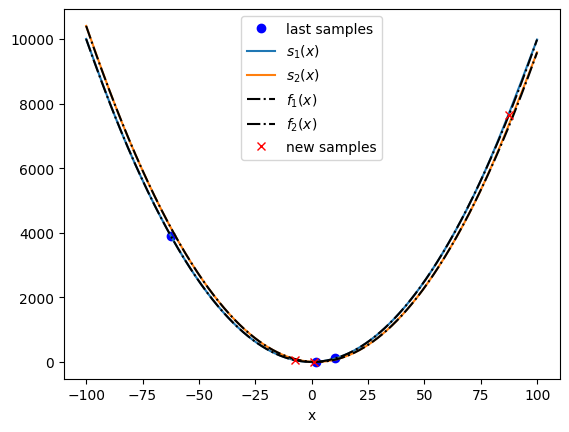

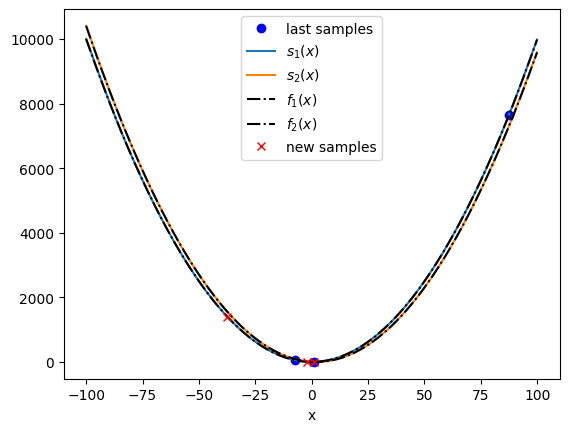

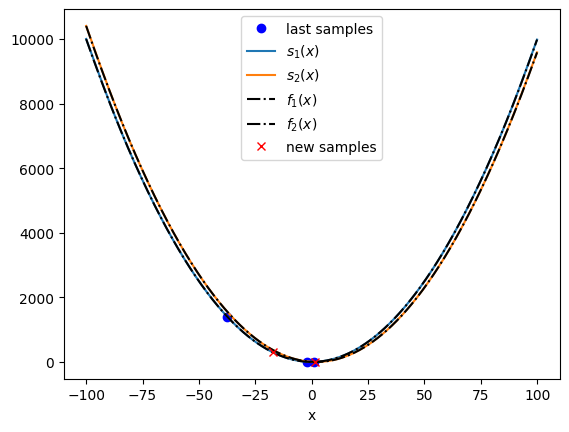

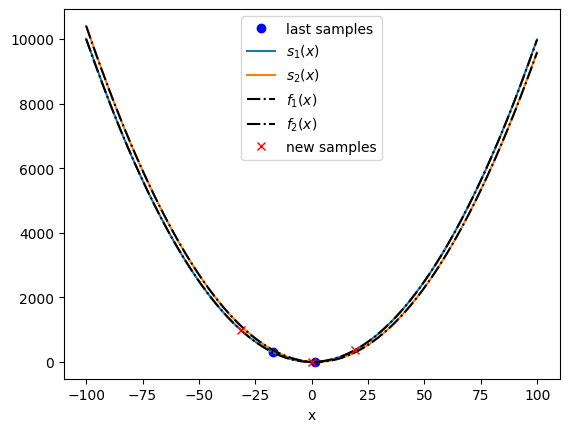

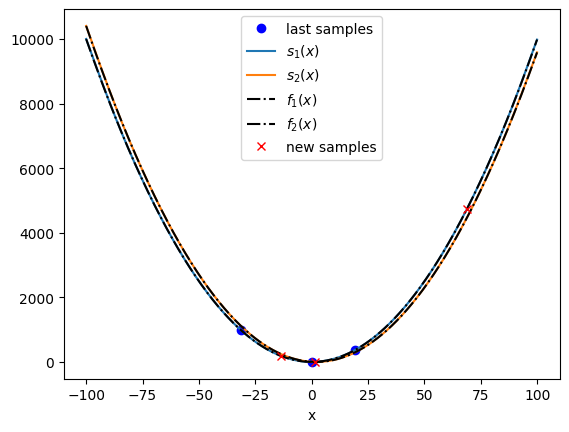

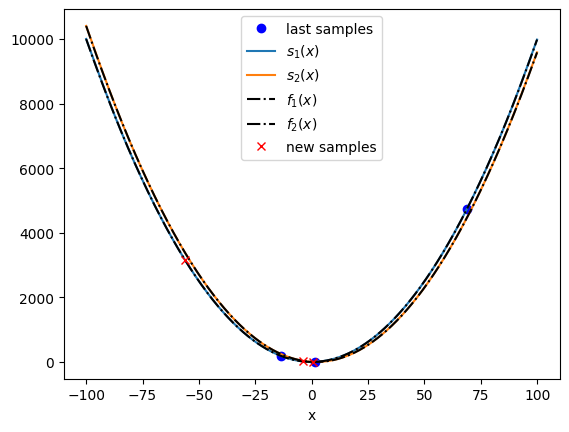

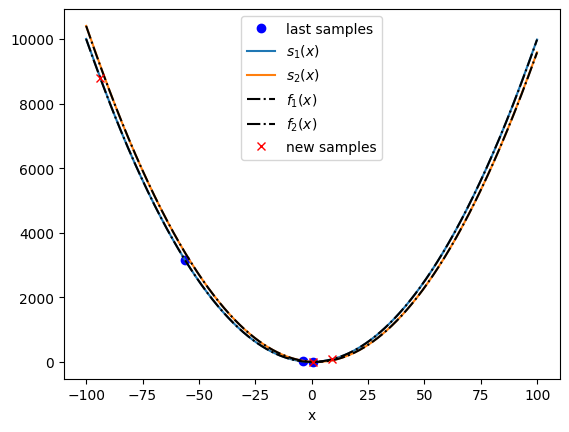

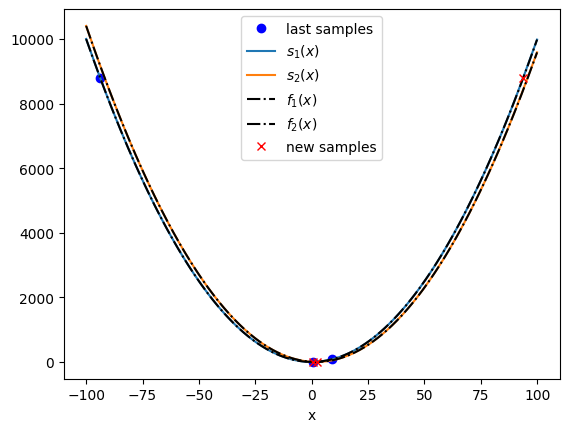

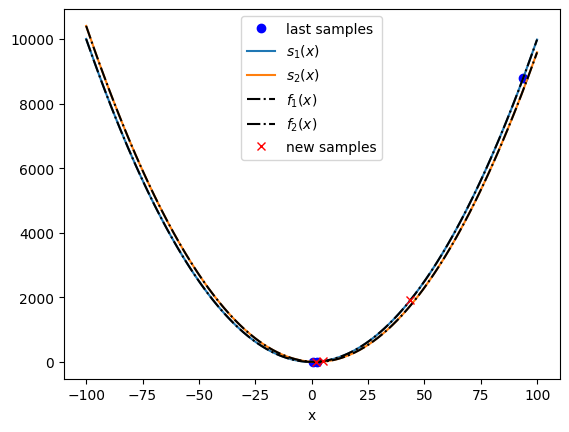

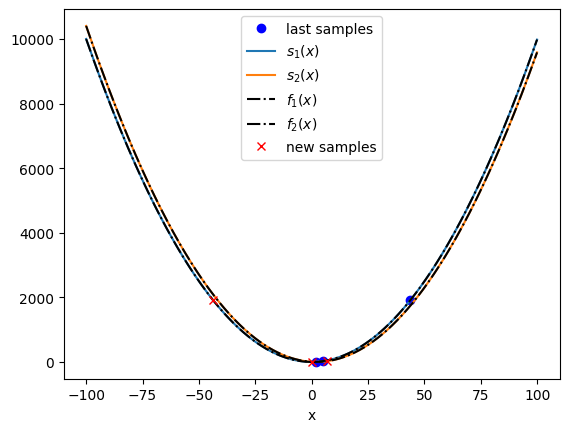

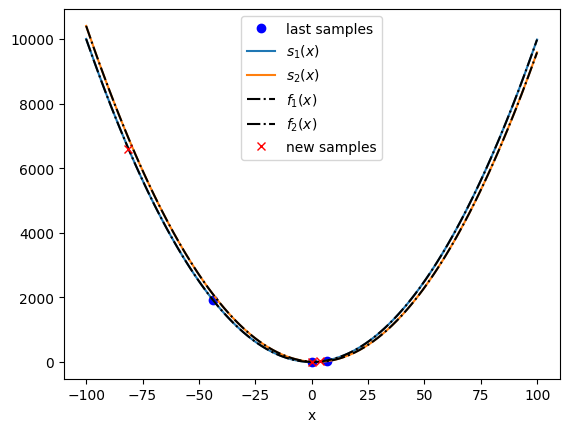

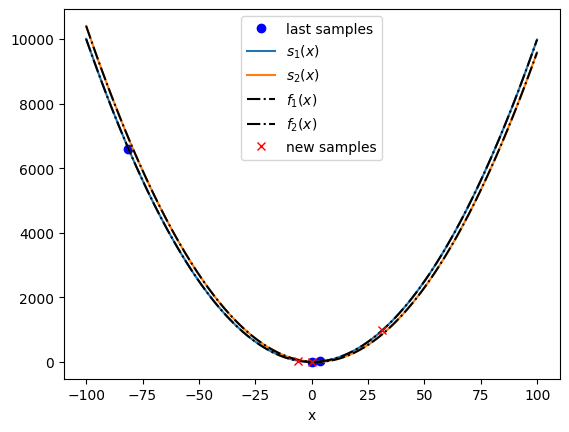

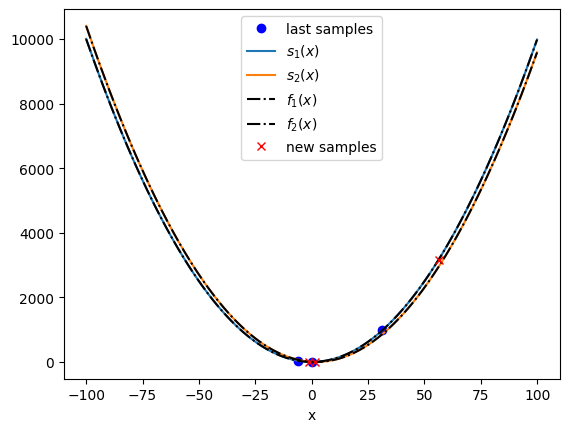

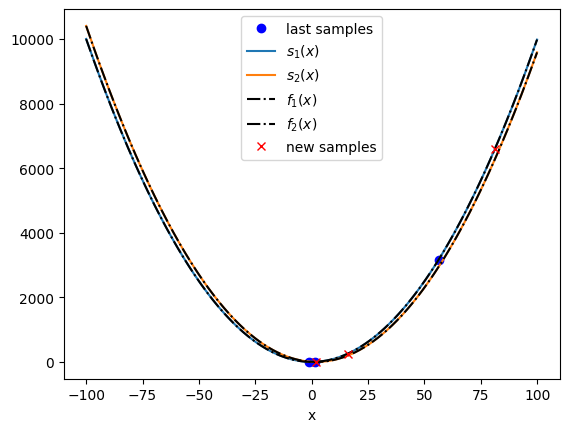

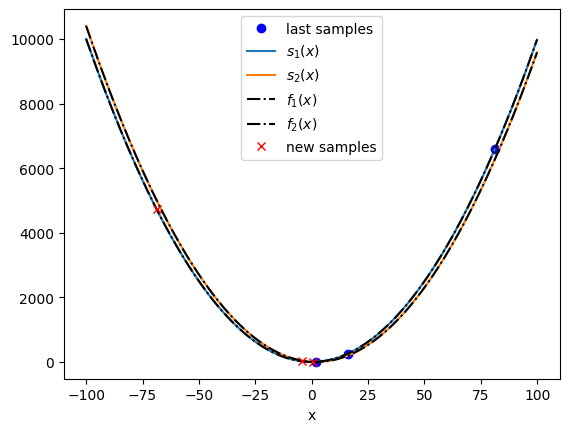

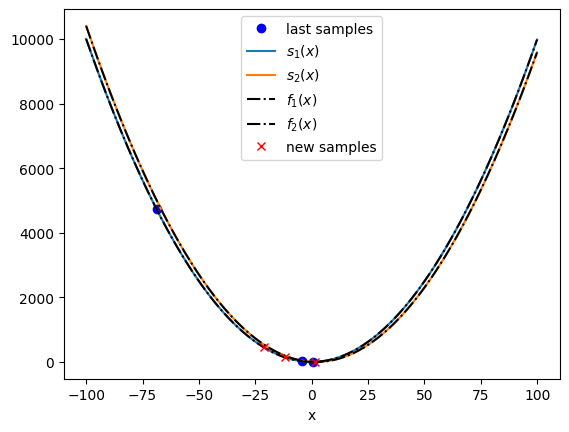

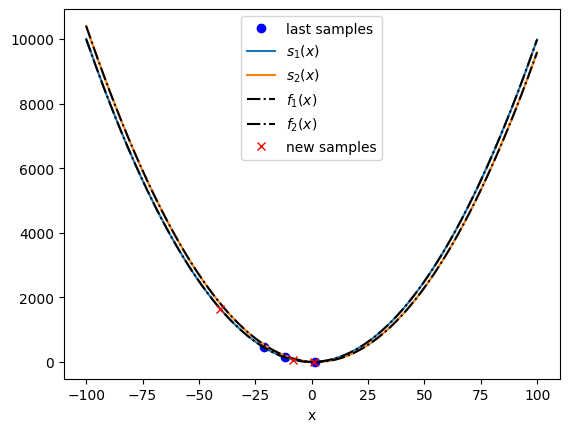

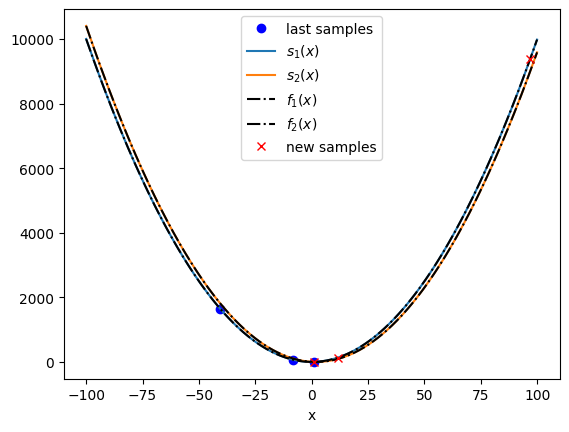

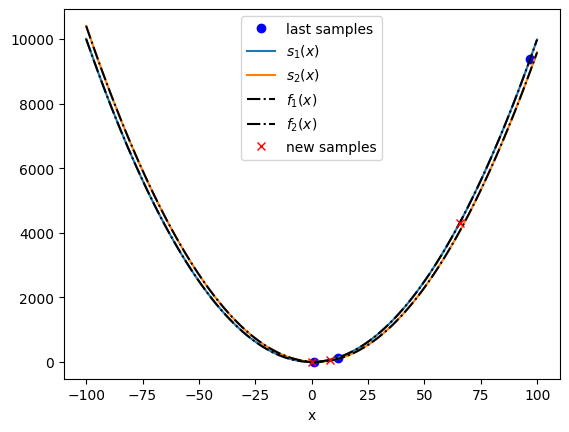

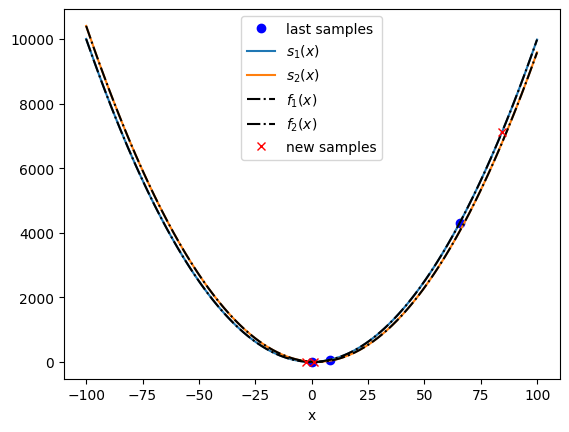

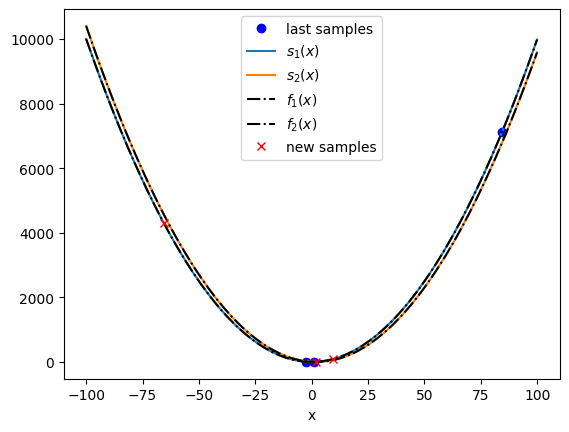

In [7]:
def plotIteration(i):
    i0 = samplesUpToIter[i-1] if i > 0 else 0
    i1 = samplesUpToIter[i]
    i2 = samplesUpToIter[i+1]

    plt.plot(samples[i0:i1], f1[i0:i1], 'bo', label="last samples")
    # plt.plot(samples[i0:i1], f2[i0:i1], 'bo')

    s = [RbfModel(), RbfModel()]
    for j in range(2):
        s[j].update_samples(res.samples[:i1,:])
        s[j].update_coefficients(res.fsamples[:i1,j])

    x = np.arange(-100, 100, 0.1).reshape(-1, 1)
    y1 = s[0].eval(x)[0]
    y2 = s[1].eval(x)[0]
    fx = objf(x)
    f1x = [f[0] for f in fx]
    f2x = [f[1] for f in fx]

    plt.plot(x.flatten(), y1, '-', label=r"$s_1(x)$")
    plt.plot(x.flatten(), y2, '-', label=r"$s_2(x)$")
    plt.plot(x.flatten(), f1x, 'k-.', label=r"$f_1(x)$")
    plt.plot(x.flatten(), f2x, 'k-.', label=r"$f_2(x)$")

    plt.plot(samples[i1:i2], f1[i1:i2], 'rx', label="new samples")
    # plt.plot(samples[i1:i2], f2[i1:i2], 'rx')

    # plt.plot(samples[i1:i2], np.ones(i2-i1), 'ro', label="new samples")
    plt.xlabel("x")
    plt.legend()
    plt.show()

for i in range(len(samplesUpToIter)-1):
    plotIteration(i)

In [8]:
# Add last samples to the surrogate models
if surrogateModels[0].nsamples() < samplesUpToIter[-1]:
    objdim = 2
    for i in range(objdim):
        surrogateModels[i].update_samples(res.samples[samplesUpToIter[-2]:,:])
        surrogateModels[i].update_coefficients(res.fsamples[samplesUpToIter[-2]:,i])

surrogateModels[0].nsamples()

100

In [9]:
surrogateModels[0].nsamples()

100

In [10]:
# Continue optimization

maxeval2 = 30
res2 = socemo(objf, bounds, maxeval2, surrogateModels=surrogateModels, acquisitionFunc=localAcquisition, acquisitionFuncGlobal=globalAcquisition, disp=True)

Iteration: 0
fEvals: 0
Time to update surrogate model: 0.000000 s
Fill gaps in the Pareto front: 1 points in 2.371693 s
Random perturbation of the currently nondominated points: 0 points in 0.085707 s
Minimum point sampling: 1 points in 2.205261 s
Uniform random points and scoring: 1 points in 0.001979 s
Solving the surrogate multiobjective problem: 0 points in 1.624792 s
Number of new samples:  3
Iteration: 1
fEvals: 3
Time to update surrogate model: 0.004321 s
Fill gaps in the Pareto front: 1 points in 1.904577 s
Random perturbation of the currently nondominated points: 0 points in 0.180428 s
Minimum point sampling: 1 points in 2.568251 s
Uniform random points and scoring: 1 points in 0.001492 s
Solving the surrogate multiobjective problem: 0 points in 1.911438 s
Number of new samples:  3
Iteration: 2
fEvals: 6
Time to update surrogate model: 0.000500 s
Fill gaps in the Pareto front: 1 points in 1.886018 s
Random perturbation of the currently nondominated points: 0 points in 0.099395

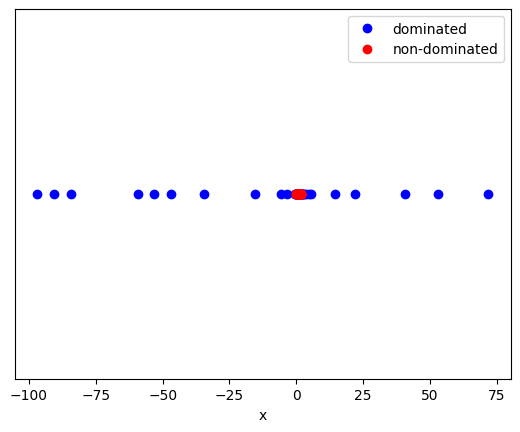

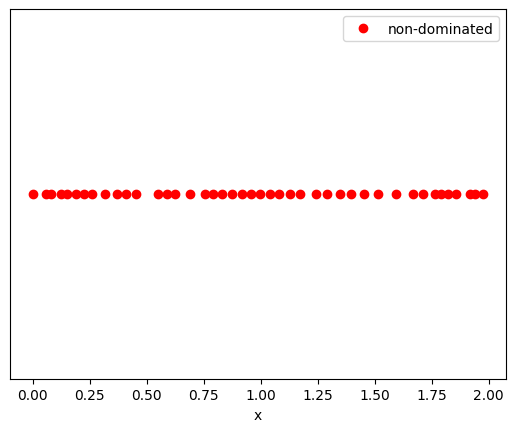

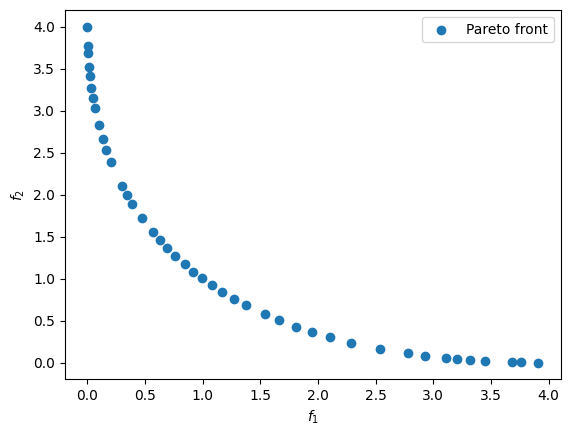

In [11]:
from matplotlib import pyplot as plt

samples = res2.samples.flatten()
f1 = res2.fsamples[:,0].flatten()
f2 = res2.fsamples[:,1].flatten()
nondominated = res2.x
paretoFront = res2.fx

plt.plot(samples, np.ones_like(samples), 'bo', label="dominated")
# plt.plot(samples, f2, 'bo')
plt.plot(nondominated, np.ones_like(nondominated), 'ro', label="non-dominated")
# plt.plot(nondominated, paretoFront[:,1], 'ro')
plt.xlabel("x")
plt.yticks([], [])
plt.legend()
plt.show()

plt.plot(nondominated, np.ones_like(nondominated), 'ro', label="non-dominated")
# plt.plot(nondominated, paretoFront[:,1], 'ro')
plt.xlabel("x")
plt.yticks([], [])
plt.legend()
plt.show()

plt.scatter(res2.fx[:, 0], res2.fx[:, 1], label="Pareto front")
plt.xlabel(r"$f_1$")
plt.ylabel(r"$f_2$")
plt.legend()
plt.show()